In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download -d oddrationale/mnist-in-csv if not in competition
!kaggle competitions download -c dogs-vs-cats

Saving kaggle.json to kaggle.json
 99% 806M/812M [00:03<00:00, 263MB/s]
100% 812M/812M [00:03<00:00, 213MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import random
import tensorflow as tf


from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile



In [ ]:
!unzip /content/dogs-vs-cats.zip

Archive:  /content/dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip /content/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

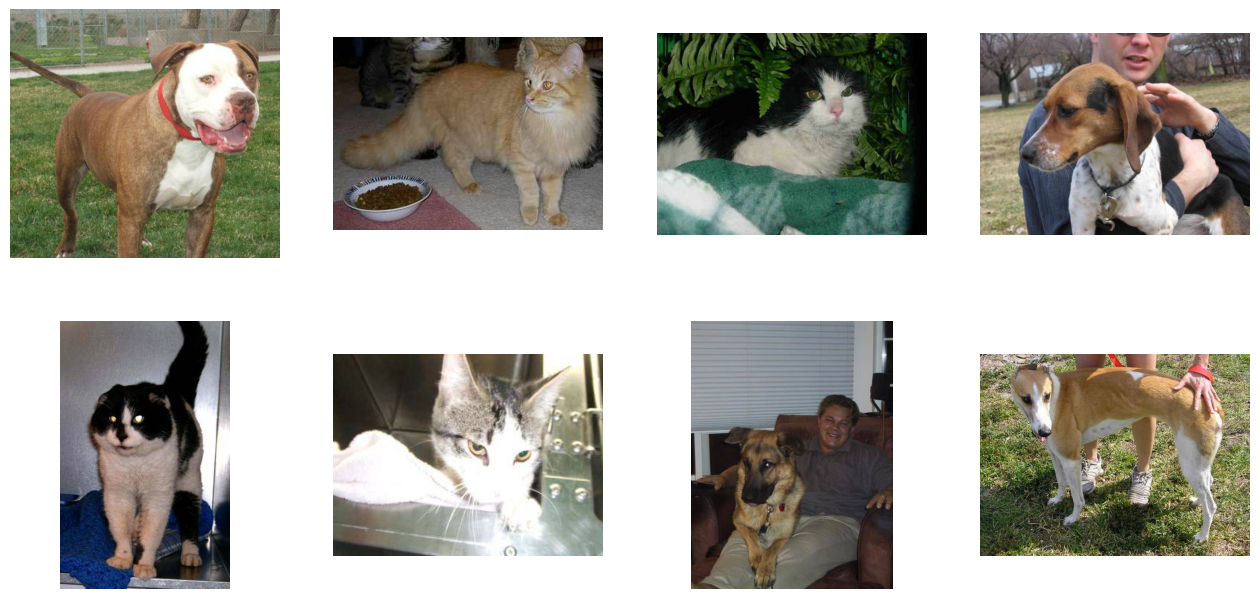

In [ ]:
import matplotlib.image as mpimg
plt.figure(figsize=(16,16))
images = os.listdir('/content/train')
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join('/content/train',img))
    fig.imshow(img)

In [ ]:
try:
    parent_dir = '/content/cats-v-dogs'
    os.mkdir(parent_dir)
    for dir in ['training','validation']:
        path = os.path.join(parent_dir,dir)
        os.mkdir(path)
        for dir in ['cats','dogs']:
            n_path = os.path.join(path,dir)
            os.mkdir(n_path)
except OSError:
    print("Existed")



Existed


In [ ]:
src_dir = '/content/train'

cats_train_dir ='/content/cats-v-dogs/training/cats'
cats_valid_dir ='/content/cats-v-dogs/validation/cats'

dogs_train_dir ='/content/cats-v-dogs/training/dogs'
dogs_valid_dir ='/content/cats-v-dogs/validation/dogs'
cats = [img for img in os.listdir(src_dir) if img[:3]=='cat']
dogs = [img for img in os.listdir(src_dir) if img[:3]=='dog']
# Take 10% of training images for validation
cats_valid_sample = random.sample(cats,int(0.1*len(cats)))
dogs_valid_sample = random.sample(dogs,int(0.1*len(dogs)))

In [ ]:
for img in os.listdir(src_dir):
    src_img = os.path.join(src_dir, img)

    if img[:3] == 'cat':
        if img in cats_valid_sample:
            dest_img = os.path.join(cats_valid_dir, img)
        else:
            dest_img = os.path.join(cats_train_dir, img)

    elif img[:3] == 'dog':
        if img in dogs_valid_sample:
            dest_img = os.path.join(dogs_valid_dir, img)
        else:
            dest_img = os.path.join(dogs_train_dir, img)
    if not os.path.exists(dest_img):
        shutil.copyfile(src_img, dest_img)

In [ ]:
print('No. of ALL cats : ', len(cats))
print('No. of cats for training: ', len(os.listdir(cats_train_dir)))
print('No. of cats for validation: ', len(os.listdir(cats_valid_dir)))

print('\nNo. of ALL dogs : ', len(dogs))
print('No. of dogs for training: ', len(os.listdir(dogs_train_dir)))
print('No. of dogs for validation: ', len(os.listdir(dogs_valid_dir)))

No. of ALL cats :  12500
No. of cats for training:  11250
No. of cats for validation:  1250

No. of ALL dogs :  12500
No. of dogs for training:  11250
No. of dogs for validation:  1250


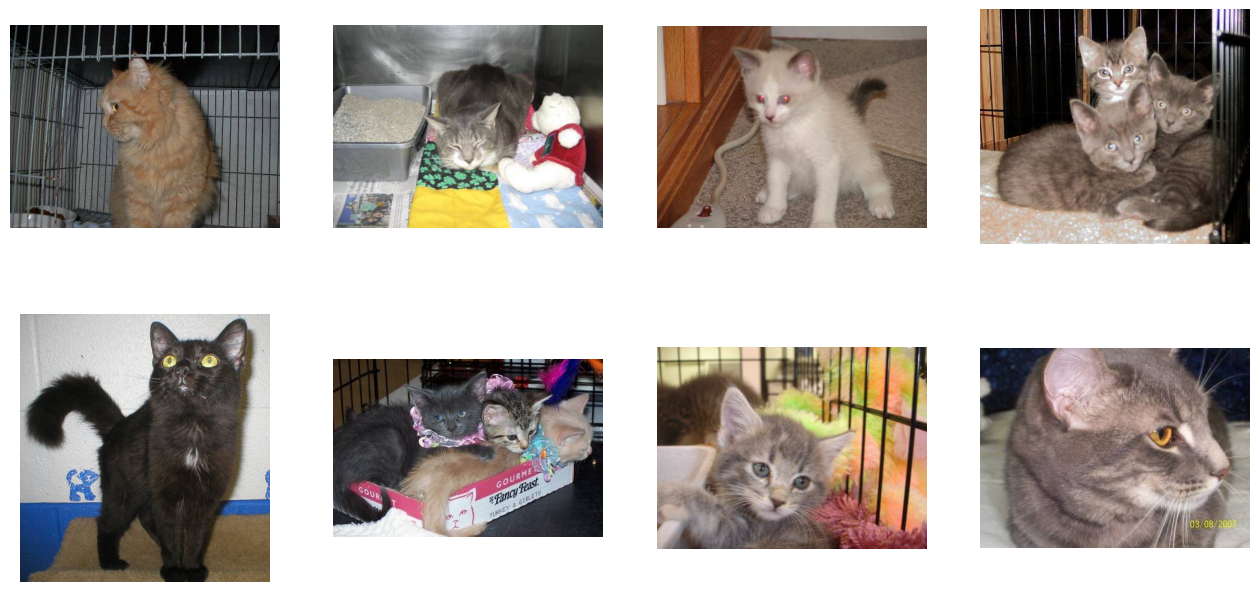

In [ ]:
plt.figure(figsize=(16,16))

images = os.listdir(cats_train_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(cats_train_dir, img))
    fig.imshow(img)

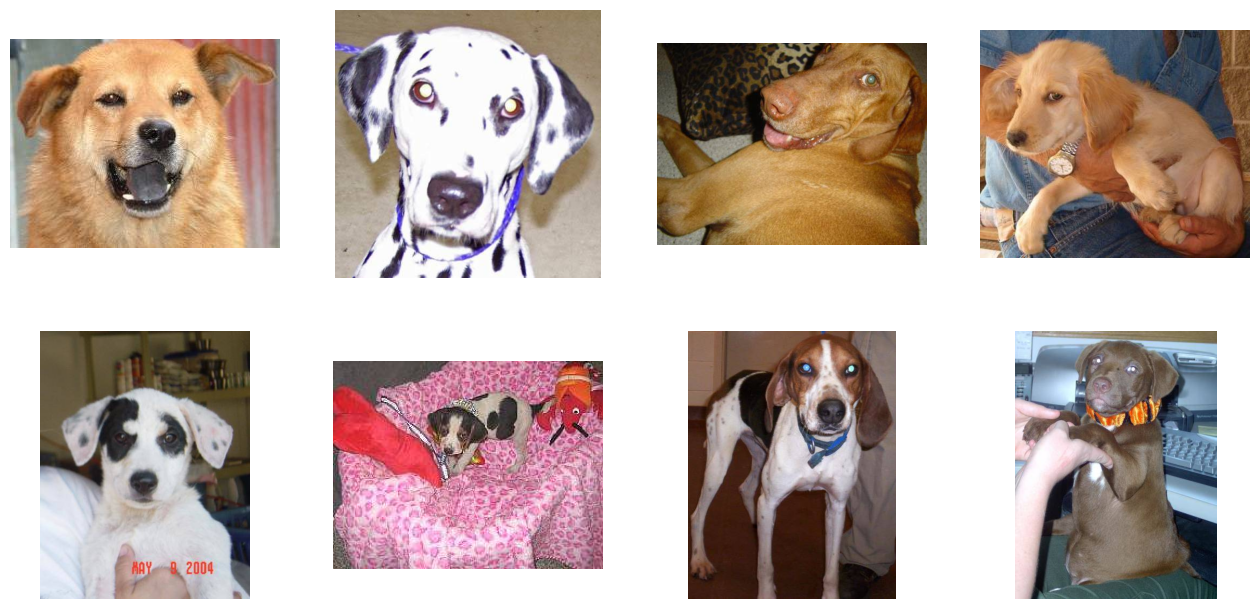

In [ ]:
plt.figure(figsize=(16,16))

images = os.listdir(dogs_train_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(dogs_train_dir, img))
    fig.imshow(img)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)

train_dir = '/content/cats-v-dogs/training'
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150,150),
                                                    batch_size =32,class_mode='binary')

valid_dir = '/content/cats-v-dogs/validation'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150,150),
                                                    batch_size =32,class_mode='binary')



Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
print(valid_generator.class_indices)

In [ ]:
model = Sequential([
    Conv2D(32,(3,3),activation ='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64,(3,3),activation ='relu'),
    MaxPooling2D(2,2),
    Conv2D(128,(3,3),activation ='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128,activation='relu'),
    Dense(1,activation='sigmoid')])
model.compile(optimizer='adamax',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_generator,epochs=5,validation_data=valid_generator)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6072 - loss: 0.6559

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 1027s 1s/step - accuracy: 0.6073 - loss: 0.6558 - val_accuracy: 0.7436 - val_loss: 0.5137
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 1019s 1s/step - accuracy: 0.7713 - loss: 0.4813 - val_accuracy: 0.7956 - val_loss: 0.4318
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 1007s 1s/step - accuracy: 0.8178 - loss: 0.4073 - val_accuracy: 0.8252 - val_loss: 0.3946
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 1028s 1s/step - accuracy: 0.8470 - loss: 0.3433 - val_accuracy: 0.8344 - val_loss: 0.3864
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 974s 1s/step - accuracy: 0.8719 - loss: 0.2981 - val_accuracy: 0.8336 - val_loss: 0.3868


In [ ]:
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(valid_generator)[1]
print('Train Accuracy: ',train_acc)
print('Validation Accuracy: ',valid_acc)

704/704 ━━━━━━━━━━━━━━━━━━━━ 296s 420ms/step - accuracy: 0.8977 - loss: 0.2497
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 395ms/step - accuracy: 0.8392 - loss: 0.3755
Train Accuracy:  0.8967111110687256
Validation Accuracy:  0.8335999846458435
